In [1]:
# necessary Imports
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_excel('/content/drive/MyDrive/Datasets/korea_data.xlsx')
df.head(10)

,Year,GDP growth (annual %),Gross capital formation (% of GDP),Population growth (annual %),"Birth rate, crude (per 1,000 people)",Broad money growth (annual %),Final consumption expenditure (annual % growth),General government final consumption expenditure (annual % growth),Gross capital formation (annual % growth),Households and NPISHs Final consumption expenditure (annual % growth),"Unemployment, total (% of total labor force) (national estimate)"
0,1969,14.541235,29.943577,2.263434,30.663,60.984733,10.693249,10.640799,29.908118,10.700325,4.8600
1,1970,9.997407,26.338200,2.184174,31.2,27.422864,10.161539,7.279573,0.058667,10.557300,4.5100
2,1971,10.454693,25.558501,1.971324,31.2,20.844481,9.330434,8.610547,15.172870,9.426969,4.5700
3,1972,7.150715,21.404761,1.875999,28.4,33.815028,5.788458,8.134824,-13.056701,5.471355,4.5900
4,1973,14.827554,25.872858,1.768293,28.3,36.415629,8.089952,2.287729,32.098276,8.927295,4.0400
5,1974,9.460873,32.533408,1.712705,26.6,24.036652,7.323853,7.288576,31.493083,7.328337,4.1500
6,1975,7.863512,28.959267,1.682000,24.8,28.231630,5.714445,6.960465,-1.493720,5.539527,4.1800
7,1976,13.115159,27.555990,1.596559,22.2,33.484656,7.182714,0.560957,23.006080,8.254930,3.8076
8,1977,12.277661,30.630713,1.559039,22.7,39.705763,5.701161,7.468013,31.486450,5.401645,3.8057
9,1978,10.774491,34.532492,1.519197,20.3,34.971026,7.924074,5.582315,30.873052,8.340376,3.1673


In [4]:
df.tail(10)

,Year,GDP growth (annual %),Gross capital formation (% of GDP),Population growth (annual %),"Birth rate, crude (per 1,000 people)",Broad money growth (annual %),Final consumption expenditure (annual % growth),General government final consumption expenditure (annual % growth),Gross capital formation (annual % growth),Households and NPISHs Final consumption expenditure (annual % growth),"Unemployment, total (% of total labor force) (national estimate)"
39,2008,2.829223,33.018504,0.759317,9.4,11.956204,2.152043,5.081962,-0.967182,1.372883,3.2
40,2009,0.707510,28.465658,0.514683,9,9.885949,1.271568,5.240622,-10.143221,0.162872,3.6
41,2010,6.496794,32.022875,0.498225,9.4,5.978876,4.258940,3.848100,17.841951,4.379593,3.7
42,2011,3.681689,32.958833,0.768972,9.4,5.475862,2.746709,2.211640,3.478558,2.900586,3.4
43,2012,2.292398,31.001229,0.525714,9.6,4.806465,2.246066,3.374311,-2.299833,1.923148,3.2
44,2013,2.896205,29.102217,0.455219,8.6,4.638891,2.191130,3.261377,-0.118665,1.882099,3.1
45,2014,3.341448,29.276910,0.628150,8.6,8.144493,2.042800,3.046199,5.262495,1.747117,3.5
46,2015,2.790236,28.918112,0.527288,8.6,8.190748,2.385188,2.988499,7.297390,2.203974,3.6
47,2016,2.929305,29.252387,0.451318,7.9,7.123156,2.981150,4.477185,5.610214,2.525765,3.7
48,2017,3.062768,31.075651,0.429345,..,5.104741,2.802722,3.424837,10.107801,2.608641,3.7


In [5]:
# replace the '..' with nan
df = df.replace('..','nan')

# set the index to the year column
df = df.set_index('Year')

# set the data type and select rows up to 2016
df = df.astype(float)
df = df.loc['1969':'2016']

column_names = {'Unemployment, total (% of total labor force) (national estimate)':'unemployment',
                'GDP growth (annual %)': 'gdp_growth',
                'Gross capital formation (% of GDP)':'gross_capital_formation',
                'Population growth (annual %)':'pop_growth', 
                'Birth rate, crude (per 1,000 people)':'birth_rate',
                'Broad money growth (annual %)':'broad_money_growth',                
                'Final consumption expenditure (% of GDP)':'final_consum_gdp',
                'Final consumption expenditure (annual % growth)':'final_consum_growth',
                'General government final consumption expenditure (annual % growth)':'gov_final_consum_growth',
                'Gross capital formation (annual % growth)':'gross_cap_form_growth',
                'Households and NPISHs Final consumption expenditure (annual % growth)':'hh_consum_growth'}

# rename columns
df = df.rename(columns = column_names)

# check for nulls
display('-'*100)
display(df.isnull().any())

# display the first five rows
display('-'*100)
display(df.head())

'----------------------------------------------------------------------------------------------------'

gdp_growth                 False
gross_capital_formation    False
pop_growth                 False
birth_rate                 False
broad_money_growth         False
final_consum_growth        False
gov_final_consum_growth    False
gross_cap_form_growth      False
hh_consum_growth           False
unemployment               False
dtype: bool

'----------------------------------------------------------------------------------------------------'

,gdp_growth,gross_capital_formation,pop_growth,birth_rate,broad_money_growth,final_consum_growth,gov_final_consum_growth,gross_cap_form_growth,hh_consum_growth,unemployment
Year,,,,,,,,,,
1969,14.541235,29.943577,2.263434,30.663,60.984733,10.693249,10.640799,29.908118,10.700325,4.86
1970,9.997407,26.338200,2.184174,31.200,27.422864,10.161539,7.279573,0.058667,10.557300,4.51
1971,10.454693,25.558501,1.971324,31.200,20.844481,9.330434,8.610547,15.172870,9.426969,4.57
1972,7.150715,21.404761,1.875999,28.400,33.815028,5.788458,8.134824,-13.056701,5.471355,4.59
1973,14.827554,25.872858,1.768293,28.300,36.415629,8.089952,2.287729,32.098276,8.927295,4.04


,gdp_growth,gross_capital_formation,pop_growth,birth_rate,broad_money_growth,final_consum_growth,gov_final_consum_growth,gross_cap_form_growth,hh_consum_growth,unemployment
gdp_growth,1.000000,0.086712,0.567216,0.553225,0.335249,0.855835,0.098183,0.825496,0.868848,-0.160783
gross_capital_formation,0.086712,1.000000,-0.215243,-0.241668,-0.163803,0.266617,0.118075,0.187885,0.268592,-0.618524
pop_growth,0.567216,-0.215243,1.000000,0.978754,0.548336,0.470449,0.357042,0.317556,0.442187,0.279486
birth_rate,0.553225,-0.241668,0.978754,1.000000,0.530563,0.458319,0.370517,0.305254,0.428266,0.313783
broad_money_growth,0.335249,-0.163803,0.548336,0.530563,1.000000,0.290507,0.287270,0.235561,0.267220,0.336335
final_consum_growth,0.855835,0.266617,0.470449,0.458319,0.290507,1.000000,0.323250,0.700392,0.993526,-0.299310
gov_final_consum_growth,0.098183,0.118075,0.357042,0.370517,0.287270,0.323250,1.000000,0.033376,0.216641,0.007940
gross_cap_form_growth,0.825496,0.187885,0.317556,0.305254,0.235561,0.700392,0.033376,1.000000,0.715021,-0.207261
hh_consum_growth,0.868848,0.268592,0.442187,0.428266,0.267220,0.993526,0.216641,0.715021,1.000000,-0.304797
unemployment,-0.160783,-0.618524,0.279486,0.313783,0.336335,-0.299310,0.007940,-0.207261,-0.304797,1.000000


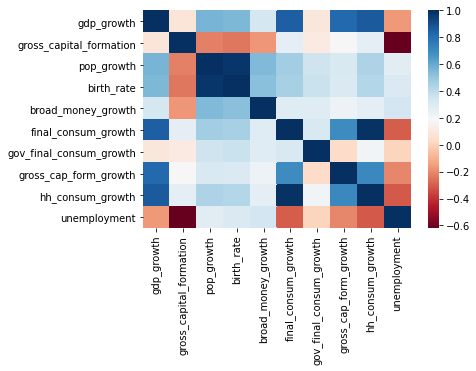

In [6]:
#calculate the correlation matrix
corr = df.corr()

#display the correlation matrix
display(corr)

# plot the correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

In [7]:
# define two data frames one before the drop and one after the drop
df_before = df
df_after = df.drop(['gdp_growth','birth_rate', 'final_consum_growth','gross_capital_formation'], axis = 1)

# the VFI does expect a constant term in the data, so we need to add one using the add_constant method
X1 = sm.tools.add_constant(df_before)
X2 = sm.tools.add_constant(df_after)

# create the series for both
series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)
series_after = pd.Series([variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])], index=X2.columns)

# display the series
print('DATA BEFORE')
print('-'*100)
display(series_before)

print('DATA AFTER')
print('-'*100)
display(series_after)

DATA BEFORE
----------------------------------------------------------------------------------------------------


const                       314.550195
gdp_growth                    9.807879
gross_capital_formation       2.430057
pop_growth                   25.759263
birth_rate                   26.174368
broad_money_growth            1.633079
final_consum_growth        2305.724583
gov_final_consum_growth      32.527332
gross_cap_form_growth         3.796420
hh_consum_growth           2129.093634
unemployment                  2.800008
dtype: float64

DATA AFTER
----------------------------------------------------------------------------------------------------


const                      27.891150
pop_growth                  1.971299
broad_money_growth          1.604644
gov_final_consum_growth     1.232229
gross_cap_form_growth       2.142992
hh_consum_growth            2.782698
unemployment                1.588410
dtype: float64

In [8]:
# get the summary
desc_df = df.describe()

# add the standard deviation metric
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

# display it
desc_df

,gdp_growth,gross_capital_formation,pop_growth,birth_rate,broad_money_growth,final_consum_growth,gov_final_consum_growth,gross_cap_form_growth,hh_consum_growth,unemployment
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,7.280315,32.433236,1.058072,16.340896,20.426621,5.820239,5.419214,8.965681,5.879176,3.678096
std,4.209306,4.136932,0.514039,6.814683,14.748442,3.627444,2.622254,12.629912,4.227720,0.968616
min,-5.471219,21.404761,0.211998,7.900000,2.980690,-9.288825,0.560957,-29.403255,-11.894309,2.048000
25%,4.374899,29.776910,0.615602,9.950000,10.586461,3.591334,3.384407,2.114078,3.825773,3.150475
50%,7.513471,32.335229,0.985132,15.150000,17.807598,6.531163,5.056509,7.431966,6.999971,3.700000
75%,10.376191,34.474874,1.525765,21.750000,26.923837,8.179037,7.188470,16.210283,8.938837,4.088500
max,14.827554,41.374062,2.263434,31.200000,85.203081,10.834413,11.742807,32.098276,11.711835,6.963000
+3_std,19.908232,44.844034,2.600188,36.784945,64.671947,16.702571,13.285976,46.855416,18.562336,6.583944
-3_std,-5.347602,20.022439,-0.484044,-4.103153,-23.818705,-5.062092,-2.447547,-28.924054,-6.803985,0.772247


In [9]:
# filter the data frame to remove the values exceeding 3 standard deviations
remove_df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

# what rows were removed
df.index.difference(remove_df.index)

Int64Index([1998, 2001], dtype='int64', name='Year')

In [10]:

# define our input variable (X) & output variable
df_after = df.drop(['birth_rate', 'final_consum_growth','gross_capital_formation'], axis = 1)

X = df_after.drop('gdp_growth', axis = 1)
Y = df_after[['gdp_growth']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

# create a Linear Regression model object
regression_model = LinearRegression()

# pass through the X_train & y_train data set
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
# let's grab the coefficient of our model and the intercept
intercept = regression_model.intercept_[0]
coefficent = regression_model.coef_[0][0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

# loop through the dictionary and print the data
for coef in zip(X.columns, regression_model.coef_[0]):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

The intercept for our model is 2.08
----------------------------------------------------------------------------------------------------
The Coefficient for pop_growth is 2.0
The Coefficient for broad_money_growth is -0.0017
The Coefficient for gov_final_consum_growth is -0.21
The Coefficient for gross_cap_form_growth is 0.14
The Coefficient for hh_consum_growth is 0.51
The Coefficient for unemployment is 0.027


In [12]:
# Get multiple predictions
y_predict = regression_model.predict(X_test)

# Show the first 5 predictions
y_predict[:5]

array([[ 7.61317534],
       [ 6.31344066],
       [ 5.06818662],
       [ 4.19869856],
       [11.11885324]])

In [13]:
# define our intput
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

In [14]:
# Run the White's test
_, pval, __, f_pval = diag.het_white(est.resid, est.model.exog, retres = False)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
    
else:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity. \n")

# Run the Breusch-Pagan test
_, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity.")

else:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity.")

0.43365711028669596 0.5090811918586966
----------------------------------------------------------------------------------------------------
For the White's Test
The p-value was 0.4337
We fail to reject the null hypthoesis, so there is no heterosecdasticity. 

0.251836467012024 0.266279455785409
----------------------------------------------------------------------------------------------------
For the Breusch-Pagan's Test
The p-value was 0.2518
We fail to reject the null hypthoesis, so there is no heterosecdasticity.


The number of lags will be 9
----------------------------------------------------------------------------------------------------
The lowest p-value found was 0.1596
We fail to reject the null hypthoesis, so there is no autocorrelation.
----------------------------------------------------------------------------------------------------


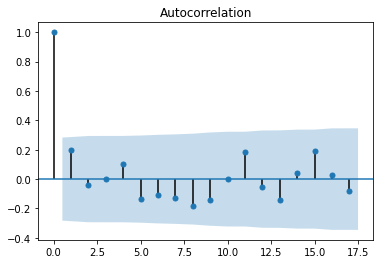

In [15]:
# test for autocorrelation
from statsmodels.stats.stattools import durbin_watson

# calculate the lag, optional
lag = min(10, (len(X)//5))
print('The number of lags will be {}'.format(lag))
print('-'*100)

# run the Ljung-Box test for no autocorrelation of residuals
# test_results = diag.acorr_breusch_godfrey(est, nlags = lag, store = True)
test_results = diag.acorr_ljungbox(est.resid, lags = lag)

# grab the p-values and the test statistics
ibvalue, p_val = test_results

# print the results of the test
if min(p_val) > 0.05:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We fail to reject the null hypthoesis, so there is no autocorrelation.")
    print('-'*100)
else:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We reject the null hypthoesis, so there is autocorrelation.")
    print('-'*100)

# plot autocorrelation
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

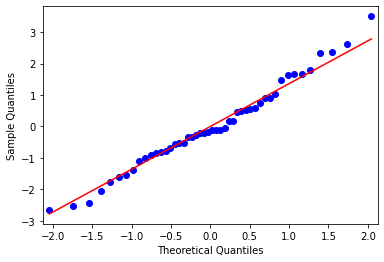

The mean of the residuals is -5.079e-15


In [16]:
import pylab

# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))


In [17]:
import math
# calculate the mean squared error
model_mse = mean_squared_error(y_test, y_predict)

# calculate the mean absolute error
model_mae = mean_absolute_error(y_test, y_predict)

# calulcate the root mean squared error
model_rmse =  math.sqrt(model_mse)

# display the output
print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE 0.707
MAE 0.611
RMSE 0.841


In [18]:
model_r2 = r2_score(y_test, y_predict)
print("R2: {:.2}".format(model_r2))

R2: 0.86


In [19]:
# make some confidence intervals, 95% by default
est.conf_int()

,0,1
const,-0.323322,4.210608
pop_growth,0.997064,3.366766
broad_money_growth,-0.037652,0.036865
gov_final_consum_growth,-0.372408,-0.005139
gross_cap_form_growth,0.079057,0.179616
hh_consum_growth,0.325648,0.667975
unemployment,-0.570237,0.558631


In [20]:
# estimate the p-values
est.pvalues

const                      9.088069e-02
pop_growth                 5.996378e-04
broad_money_growth         9.830934e-01
gov_final_consum_growth    4.419934e-02
gross_cap_form_growth      5.978663e-06
hh_consum_growth           6.801951e-07
unemployment               9.835355e-01
dtype: float64

In [21]:
# print out a summary
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:             gdp_growth   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     57.17
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           2.36e-18
Time:                        08:38:36   Log-Likelihood:                -82.903
No. Observations:                  48   AIC:                             179.8
Df Residuals:                      41   BIC:                             192.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [22]:
# define our input variable (X) & output variable
df_after = df.drop(['birth_rate', 'final_consum_growth','gross_capital_formation','broad_money_growth',
                              'unemployment'], axis = 1)

X = df_after.drop('gdp_growth', axis = 1)
Y = df_after[['gdp_growth']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

# create a Linear Regression model object
regression_model = LinearRegression()

# pass through the X_train & y_train data set
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:

# define our intput
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:             gdp_growth   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     89.94
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           2.61e-20
Time:                        08:45:58   Log-Likelihood:                -82.904
No. Observations:                  48   AIC:                             175.8
Df Residuals:                      43   BIC:                             185.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [24]:
import pickle

# pickle the model
with open('my_mulitlinear_regression.sav','wb') as f:
     pickle.dump(regression_model, f)

# load it back in
with open('my_mulitlinear_regression.sav', 'rb') as pickle_file:
     regression_model_2 = pickle.load(pickle_file)

# make a new prediction
regression_model_2.predict([X_test.loc[2002]])

array([[7.6042968]])